In [1]:
!pip install obspy wget cartopy

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr


import obspy
from obspy.clients.fdsn import Client

import plotly.express as px

import wget

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib.colors import LightSource

import os.path

In [3]:
client = Client("IRIS")

In [4]:
t1 = obspy.UTCDateTime(2010,7,1)
t2 = obspy.UTCDateTime(2023,7,1)


minmagnitude = 6


minlat = None
maxlat = None
minlon = None
maxlon = None


cat = client.get_events(starttime = t1,
                        endtime = t2,
                        minmagnitude=minmagnitude,
                        minlatitude=minlat,
                        minlongitude=minlon,
                        maxlatitude=maxlat,
                        maxlongitude=maxlon)

In [5]:
cat[1234]

Event:	2014-07-19T14:14:02.290000Z | +11.709,  +57.957 | 6.0  MW

	            resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?eventid=4725406")
	             event_type: 'earthquake'
	    preferred_origin_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=24266308")
	 preferred_magnitude_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?magnitudeid=182182201")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements

In [6]:
N=1232
print('Description', cat[N].event_descriptions[0].text)
print('Magnitude  ', cat[N].magnitudes[0].mag)
print('Time       ', cat[N].origins[0].time.datetime)
print('Depth      ', cat[N].origins[0].depth)
print('Longitude  ', cat[N].origins[0].longitude)
print('Latitude   ', cat[N].origins[0].latitude)

Description FIJI ISLANDS REGION
Magnitude   6.9
Time        2014-07-21 14:54:41
Depth       615400.0
Longitude   -178.4001
Latitude    -19.8015


In [7]:
def catalog2pandas(cat):

    times  = [ev.origins[0].time.datetime for ev in cat]
    lats   = [ev.origins[0].latitude for ev in cat]
    lons   = [ev.origins[0].longitude for ev in cat]
    mags   = [ev.magnitudes[0].mag for ev in cat]
    depths = [ev.origins[0].depth for ev in cat]

    descriptions=[ev.event_descriptions[0]['text'] for ev in cat]

    origin_dict = {'time':times,
                   'latitude':lats,
                   'longitude':lons,
                   'depth':depths,
                   'magnitude':mags,
                   'description':descriptions}

    events = pd.DataFrame.from_dict(origin_dict)

    events=events.sort_values(by='time');

    return events

In [8]:
events=catalog2pandas(cat)
events

time  latitude  longitude     depth  magnitude  \
1920 2010-07-02 06:04:03.570  -13.6098   166.6541   34400.0        6.3   
1919 2010-07-04 21:55:52.370   39.6611   142.5792   30100.0        6.3   
1918 2010-07-10 11:43:33.000   11.1664   146.0823   16900.0        6.3   
1917 2010-07-12 00:11:20.060  -22.2789   -68.3159  109400.0        6.2   
1916 2010-07-14 08:32:21.850  -38.0635   -73.4649   25700.0        6.6   
...                      ...       ...        ...       ...        ...   
4    2023-06-17 11:26:20.456  -23.4652  -175.4720   22000.0        6.1   
3    2023-06-18 20:30:22.195   23.1690  -108.6940   10000.0        6.4   
2    2023-06-18 21:59:17.518  -48.6747    31.1598   10000.0        6.0   
1    2023-06-19 11:18:11.960   -4.4729   144.8345   23844.0        6.2   
0    2023-06-25 07:16:58.830  -24.0818  -175.5760    9000.0        6.2   

                           description  
1920                   VANUATU ISLANDS  
1919  NEAR EAST COAST OF HONSHU, JAPAN  
1918          SOUTH OF MARIANA ISLANDS  
1917                    NORTHERN CHILE  
1916       NEAR COAST OF CENTRAL CHILE  
...                                ...  
4                 TONGA ISLANDS REGION  
3                   GULF OF CALIFORNIA  
2                      SOUTH OF AFRICA  
1     NEAR N COAST OF NEW GUINEA, PNG.  
0               SOUTH OF TONGA ISLANDS  

[1921 rows x 6 columns]

In [9]:
import plotly.io as pio
pio.renderers.default = 'iframe'

In [10]:
fig = px.histogram(events,
             x="magnitude",
             nbins=50,
             height=400,
             width=600);
fig.show(renderer="colab")

In [11]:
events['year'] = pd.DatetimeIndex(events['time']).year # add year as a category to group by
events['marker_size'] =np.fix(np.exp(events['magnitude'])) # add marker size as exp(mag)
events['magnitude bin'] = 0.5*np.fix(2*events['magnitude']) # add marker size as exp(mag)

In [12]:
events2plot=events.loc[events.magnitude>5.5].sort_values(by='year')

fig = px.scatter_geo(events2plot,
                     lat='latitude',lon='longitude',
                     size='marker_size', color='magnitude',
                     hover_name='description', hover_data=['magnitude','depth', 'year'],
                     range_color=(6,9),
                     height=800, width=1000,
                     animation_frame="year");
fig.update_geos(resolution=110, showcountries=True)
fig.show(renderer="colab")

In [13]:
events2plot=events.loc[events.magnitude>5.5].sort_values(by='year')

fig = px.scatter_geo(events2plot,
                     lat='latitude',lon='longitude',
                     size='marker_size', color='magnitude',
                     hover_name='description', hover_data=['magnitude','depth', 'year'],
                     range_color=(6,9),
                     height=800, width=1000,
                     );
fig.update_geos(projection_type='orthographic', resolution=110, showcountries=True)
fig.show(renderer="colab")
fig.write_html('earthquakes.html')

# Juan de Fuca plate

In [14]:
url = 'https://www.gmrt.org/services/GridServer?north={maxlat}&west={minlon}&east={maxlon}&south={minlat}&layer=topo&format=netcdf&resolution=high'


url=url.format(maxlat=50,
               minlon=-135,
               maxlon=-120,
               minlat=39)

topo_data='GMRTv4_1_1_20230806topo.grd'

if os.path.isfile(topo_data)==False:
    print('Downloading GMRT topography')
    print(url)
    topo_data=wget.download(url)

print(topo_data)

https://www.gmrt.org/services/GridServer?north=50&west=-135&east=-120&south=39&layer=topo&format=netcdf&resolution=high
GMRTv4_3_1_20250812topo.grd


In [15]:
topo = xr.open_dataset(topo_data)

ny, nx = topo.dimension.values

z = topo.z.values.reshape(ny, nx)
z[np.isnan(z)] = 0

x = np.linspace(topo.x_range.values[0], topo.x_range.values[1], nx)
y = np.linspace(topo.y_range.values[1], topo.y_range.values[0], ny)

In [16]:
def plot_elevation(x,y,z, shade=True):


    central_longitude=0

    if np.max(x)>180:
        central_longitude=180
    if np.min(x)<-180:
        central_longitude=-180

    x=x-central_longitude

    if np.max(abs(x)>180):
        print('Check longitude range!')
        return np.nan


    cmap = plt.get_cmap('terrain')
    vmin = np.min(z)
    vmax = np.max(z)

    if shade:
        ls = LightSource(azdeg=315, altdeg=45)
        z = ls.shade(z, cmap=cmap,blend_mode='overlay',vert_exag=0.1)


    aspect=1/np.cos(np.pi/180*np.mean(y));


    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_longitude))

    gl=ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines=None
    gl.ylines=None

    cax=plt.imshow(z,
                   cmap=cmap,
                   vmin=vmin, vmax=vmax,
                   extent=[min(x),max(x),min(y),max(y)],
                   aspect=aspect)
    plt.colorbar(cax, shrink =0.25)
    ax.add_feature(cfeature.COASTLINE)
    return ax

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:242: DownloadWarning:

Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip



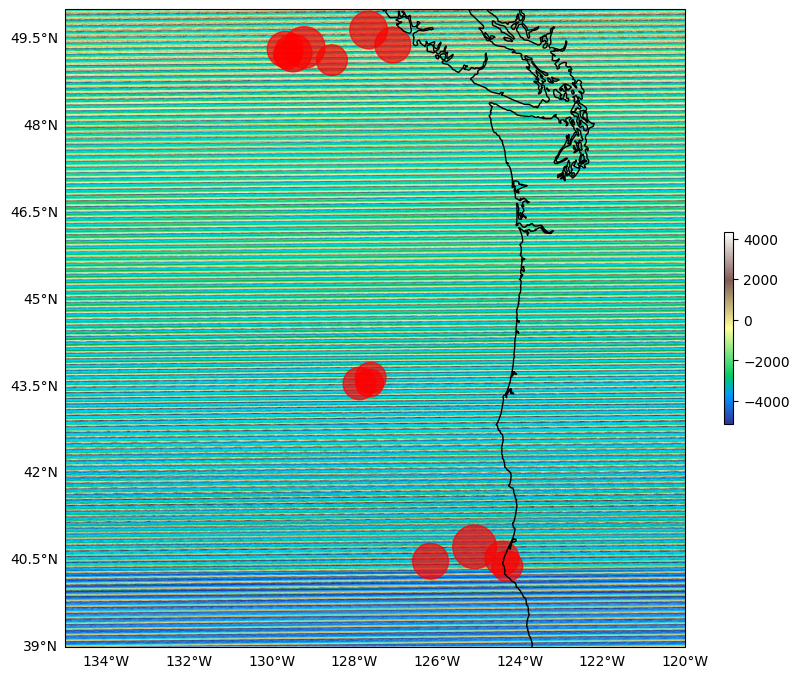

In [17]:
plt.figure(figsize=(10,10))

ax=plot_elevation(x,y,z, shade=True) #shade=False is faster but less cool

ind= (events.longitude>min(x)) & (events.longitude<max(x)) & (events.latitude>min(y)) & (events.latitude<max(y)); # selecting only those points that are within our bathymetry area

plt.scatter(events[ind].longitude,
            events[ind].latitude,
            events[ind].marker_size,
            color='r',alpha=0.7,
            transform=ccrs.PlateCarree())

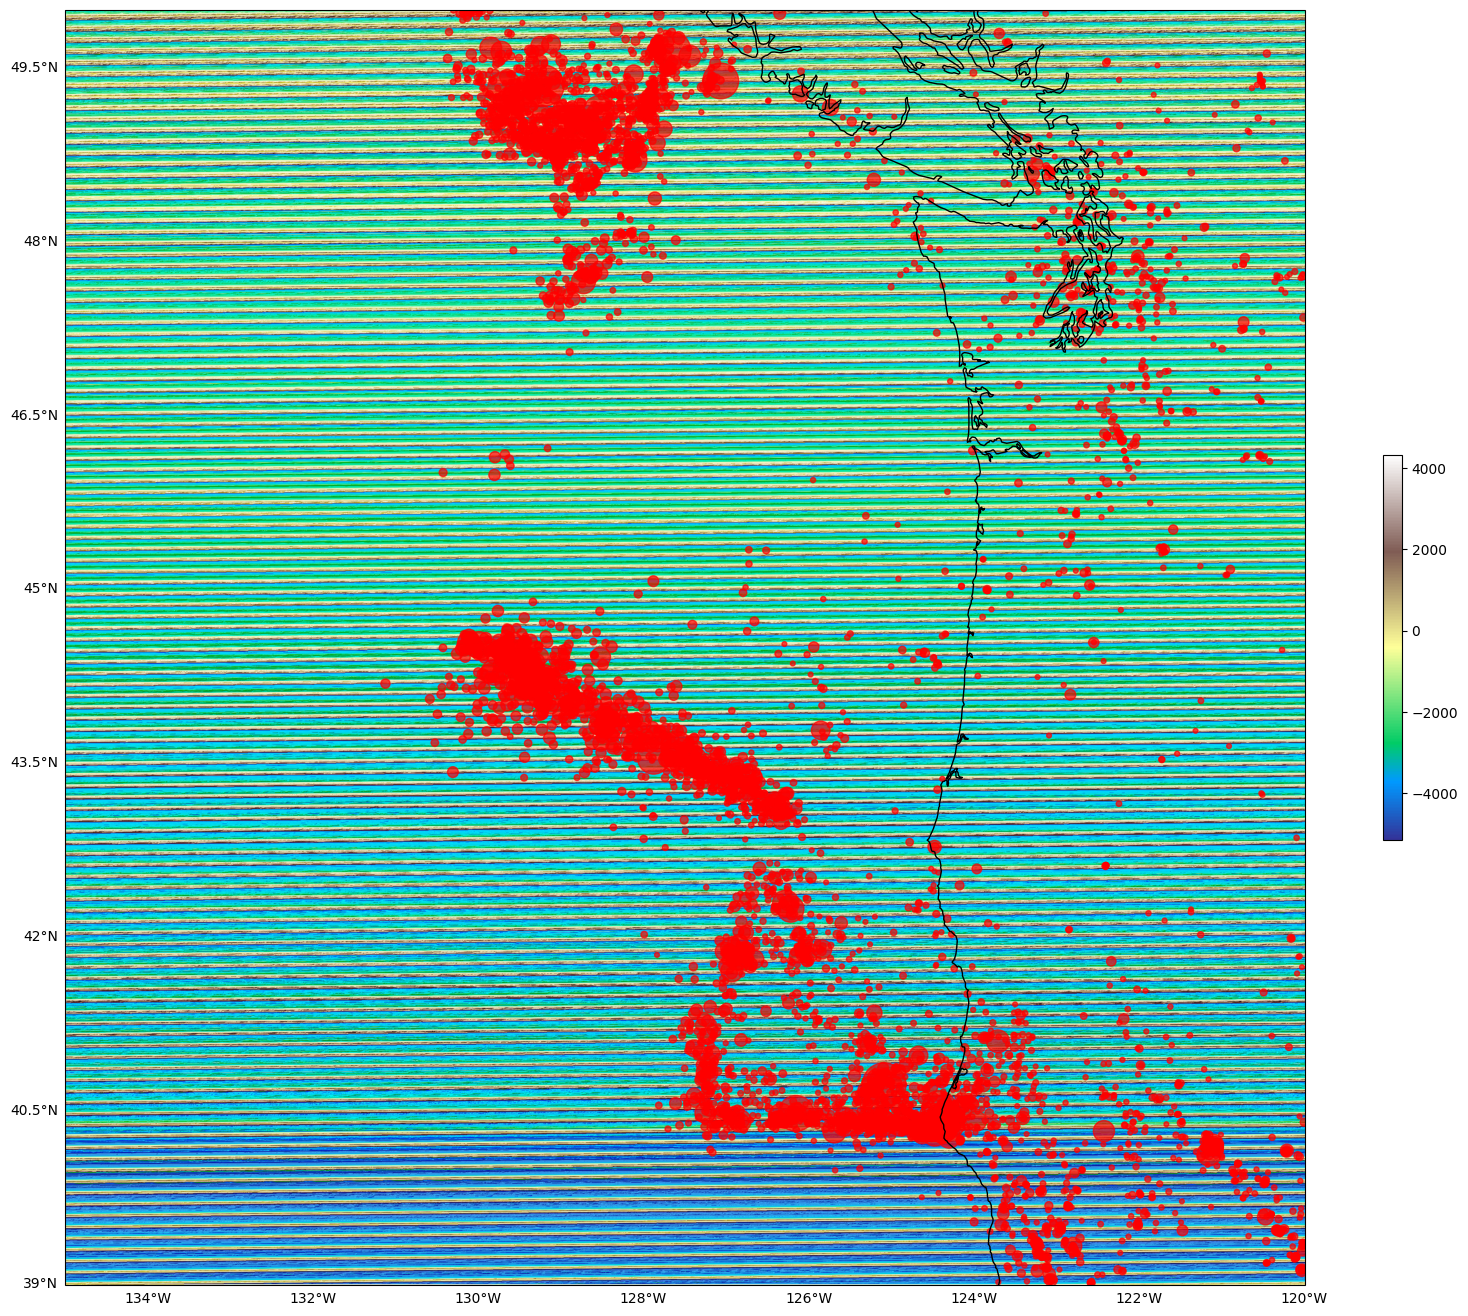

In [18]:
t1 = obspy.UTCDateTime(2010,7,1)
t2 = obspy.UTCDateTime(2023,7,1)
minmagnitude= 2.5


cat = client.get_events(starttime = t1,
                        endtime = t2,
                        minmagnitude= 2.5,
                        minlatitude=38,
                        minlongitude=-135,
                        maxlatitude=50,
                        maxlongitude=-120)

events=catalog2pandas(cat)
events

events['year'] = pd.DatetimeIndex(events['time']).year # add year as a category to group by
events['marker_size'] =np.fix(np.exp(events['magnitude'])) # add marker size as exp(mag)
events['magnitude bin'] = 0.5*np.fix(2*events['magnitude']) # add marker size as exp(mag)



plt.figure(figsize=(20,20))

ax=plot_elevation(x,y,z, shade=True) #shade=False is faster but less cool

ind= (events.longitude>min(x)) & (events.longitude<max(x)) & (events.latitude>min(y)) & (events.latitude<max(y)); # selecting only those points that are within our bathymetry area

plt.scatter(events[ind].longitude,
            events[ind].latitude,
            events[ind].marker_size,
            color='r',alpha=0.7,
            transform=ccrs.PlateCarree())